<a href="https://colab.research.google.com/github/zaidbhat1234/Image2StyleGAN/blob/main/Image2Style_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mounting your google drive containing the code files.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/

##The code should be arranged in this order of directories

In [ ]:
%cd KAUST_Internship/StyleGAN_LatentEditor

##Resolving dependencies and importing libraries

In [3]:
from stylegan_layers import  G_mapping,G_synthesis
import torch
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import torchvision
from torchvision import models
from torchvision.utils import save_image
import numpy as np
from math import log10
import matplotlib.pyplot as plt


##Setup up the network on GPU

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
g_all = nn.Sequential(OrderedDict([('g_mapping', G_mapping()),
    #('truncation', Truncation(avg_latent)),
    ('g_synthesis', G_synthesis(resolution=1024))    
    ]))

#Load the pre-trained model
g_all.load_state_dict(torch.load('weight_files/pytorch/karras2019stylegan-ffhq-1024x1024.pt', map_location=device))
g_all.eval()
g_all.to(device)
g_mapping, g_synthesis = g_all[0],g_all[1]


In [ ]:
#%cd Images2/Hierar_optim #When testing Hierarchical Optimisation

##Read Images for inverting to latent space W+ and using in various experiments

In [36]:
#Read a sample image we want to find a latent vector for
img_path = './palm_images/0036.png'
with open(img_path,"rb") as f: 
  image=Image.open(f)
  image=image.convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
image = transform(image)
image = image.unsqueeze(0)
image = image.to(device)
image = F.interpolate(image, size=(1024, 1024), mode='bilinear', align_corners=False)
print(image.shape)

torch.Size([1, 3, 1024, 1024])


##Generate random images using random W vectors

In [12]:
for i in range(20):
  z = torch.randn(1,512,device = device)
  img = g_all(z)
  img = (img +1.0)/2.0
  save_image(img.clamp(0,1),"save_image/random_SG1-{}.png".format(i+1))

##VGG Perceptual loss network to give feature vectors from 4 parts of the pre-trained VGG-16 from 2,4,14,21

In [13]:
class VGG16_perceptual(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16_perceptual, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 4):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 14):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(14, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_1 = h
        h = self.slice2(h)
        h_relu1_2 = h
        h = self.slice3(h)
        h_relu3_2 = h
        h = self.slice4(h)
        h_relu4_2 = h
        return h_relu1_1, h_relu1_2, h_relu3_2, h_relu4_2

##Loss function to calculate MSE and Perceptual losses

In [14]:
def loss_function(syn_img, img, img_p, MSE_loss, upsample, perceptual):

  #UpSample synthesized image to match the input size of VGG-16 input. 
  #Extract mid level features for real and synthesized image and find the MSE loss between them for perceptual loss. 
  #Find MSE loss between the real and synthesized images of actual size
  syn_img_p = upsample(syn_img)
  syn0, syn1, syn2, syn3 = perceptual(syn_img_p)
  r0, r1, r2, r3 = perceptual(img_p)
  mse = MSE_loss(syn_img,img)

  per_loss = 0
  per_loss += MSE_loss(syn0,r0)
  per_loss += MSE_loss(syn1,r1)
  per_loss += MSE_loss(syn2,r2)
  per_loss += MSE_loss(syn3,r3)

  return mse, per_loss

##Calculate PSNR

In [15]:
def PSNR(mse, flag = 0):
  #flag = 0 if a single image is used and 1 if loss for a batch of images is to be calculated
  if flag == 0:
    psnr = 10 * log10(1 / mse.item())
  return psnr

In [16]:
psnr_total = []

##Embedding Function to optimise the latent code W+ for GAN inversion.

In [32]:
def embedding_function(image):
  upsample = torch.nn.Upsample(scale_factor = 256/1024, mode = 'bilinear')
  img_p = image.clone()
  img_p = upsample(img_p)
  #Perceptual loss initialise object
  perceptual = VGG16_perceptual().to(device)
  
  #MSE loss object
  MSE_loss = nn.MSELoss(reduction="mean")
  #since the synthesis network expects 18 w vectors of size 1x512 thus we take latent vector of the same size
  latents = torch.zeros((1,18,512), requires_grad = True, device = device)
  #Optimizer to change latent code in each backward step
  optimizer = optim.Adam({latents},lr=0.01,betas=(0.9,0.999),eps=1e-8)


  #Loop to optimise latent vector to match the generated image to input image
  loss_ = []
  loss_psnr = []
  for e in range(1500):
    optimizer.zero_grad()
    syn_img = g_synthesis(latents)
    syn_img = (syn_img+1.0)/2.0
    mse, per_loss = loss_function(syn_img, image, img_p, MSE_loss, upsample, perceptual)
    psnr = PSNR(mse, flag = 0)
    loss = per_loss +mse
    loss.backward()
    optimizer.step()
    loss_np=loss.detach().cpu().numpy()
    loss_p=per_loss.detach().cpu().numpy()
    loss_m=mse.detach().cpu().numpy()
    loss_psnr.append(psnr)
    loss_.append(loss_np)
    if (e+1)%500==0 :
      print("iter{}: loss -- {},  mse_loss --{},  percep_loss --{}, psnr --{}".format(e+1,loss_np,loss_m,loss_p,psnr))
      save_image(syn_img.clamp(0,1),"obama{}.png".format(e+1))
      #np.save("loss_list.npy",loss_)
      #np.save("latent_W.npy".format(),latents.detach().cpu().numpy())

  plt.plot(loss_, label = 'Loss = MSELoss + Perceptual')
  plt.plot(loss_psnr, label = 'PSNR')
  plt.legend()
  return latents

iter500: loss -- 1.6195244789123535,  mse_loss --0.008855123072862625,  percep_loss --1.6106693744659424, psnr --20.52805398393311
iter1000: loss -- 1.3549870252609253,  mse_loss --0.00787959061563015,  percep_loss --1.3471074104309082, psnr --21.034963457073168
iter1500: loss -- 1.2025235891342163,  mse_loss --0.007331333588808775,  percep_loss --1.1951922178268433, psnr --21.34817018867564


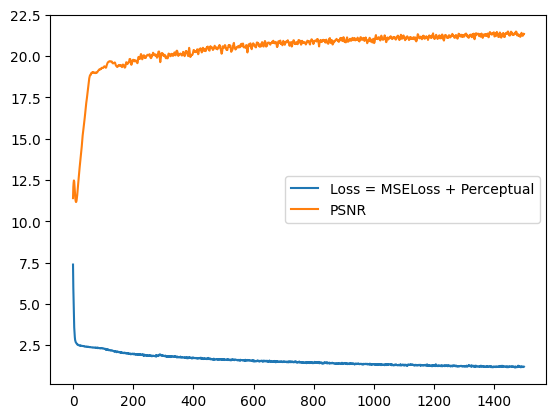

In [37]:
#Check generated images from 10 randomly generated faces 
"""Code in embed algo
rnd = np.random.RandomState(7)
z = torch.randn((1,512), requires_grad= True, device= device)
img1 = g_all(z)
img1 = (img1+1.0)/2.0
latents = g_mapping(z)
latents = torch.tensor(latents, requires_grad=True)
save_image(img1.clamp(0,1),"Random/random_image{}.png".format(i))"""

latent1 = embedding_function(image)
#latent2 = embedding_function(image1)
latent1_np = latent1.detach().cpu().numpy()
np.save("./palm_images/0036.npy", latent1_np)

##Image Morphing Experiment

In [ ]:
for i in range(20):
  a = (1/20)*i
  w = latent1 * (1-a)+ latent2 * a
  syn_img = g_synthesis(w)
  syn_img = (syn_img+1.0)/2.0
  save_image(syn_img.clamp(0,1),"save_image/encode1/Morphed{}.png".format(i))

##Hierarchical Optimisation by optimising W vector first followed by optimising W+ in second pass

In [48]:
def embedding_Hierarchical(image, folder):
  upsample = torch.nn.Upsample(scale_factor = 256/1024, mode = 'bilinear')
  img_p = image.clone()
  img_p = upsample(img_p)
  
  #Perceptual loss initialise object
  perceptual = VGG16_perceptual().to(device)
  
  #MSE loss object
  MSE_loss = nn.MSELoss(reduction="mean")
  #since the synthesis network expects 18 w vectors of size 1x512 thus we take latent vector of the same size
  latent_w = torch.zeros((1,512), requires_grad = True, device = device)
  
  #Optimizer to change latent code in each backward step
  optimizer = optim.Adam({latent_w},lr=0.01,betas=(0.9,0.999),eps=1e-8)


  #Loop to optimise latent vector to match the generated image to input image
  loss_ = []
  loss_psnr = []
  for e in range(1000):
    optimizer.zero_grad()
    latent_w1 = latent_w.unsqueeze(1).expand(-1, 18, -1)
    syn_img = g_synthesis(latent_w1)
    syn_img = (syn_img+1.0)/2.0
    mse, per_loss = loss_function(syn_img, image, img_p, MSE_loss, upsample, perceptual)
    psnr = PSNR(mse, flag = 0)
    loss = per_loss +mse
    loss.backward()
    optimizer.step()
    loss_np=loss.detach().cpu().numpy()
    loss_p=per_loss.detach().cpu().numpy()
    loss_m=mse.detach().cpu().numpy()
    loss_psnr.append(psnr)
    loss_.append(loss_np)
    if (e+1)%500==0 :
      print("iter{}: loss -- {},  mse_loss --{},  percep_loss --{}, psnr --{}".format(e+1,loss_np,loss_m,loss_p,psnr))
      save_image(syn_img.clamp(0,1),"{}Hier_pass_morphP1-{}.png".format(folder, e+1))
      #np.save("loss_list.npy",loss_)
      #np.save("latent_W.npy".format(),latents.detach().cpu().numpy())

  
  latent_w1 = latent_w.unsqueeze(1).expand(-1, 18, -1)
  latent_w1 = torch.tensor(latent_w1, requires_grad=True)
  optimizer = optim.Adam({latent_w1},lr=0.01,betas=(0.9,0.999),eps=1e-8)
  for e in range(1000):  
    optimizer.zero_grad()
    syn_img = g_synthesis(latent_w1)
    syn_img = (syn_img+1.0)/2.0
    mse, per_loss = loss_function(syn_img, image, img_p, MSE_loss, upsample, perceptual)
    psnr = PSNR(mse, flag = 0)
    loss = per_loss +mse
    loss.backward()
    optimizer.step()
    loss_np=loss.detach().cpu().numpy()
    loss_p=per_loss.detach().cpu().numpy()
    loss_m=mse.detach().cpu().numpy()
    loss_psnr.append(psnr)
    loss_.append(loss_np)
    if (e+1)%500==0 :
      print("iter{}: loss -- {},  mse_loss --{},  percep_loss --{}, psnr --{}".format(e+1,loss_np,loss_m,loss_p,psnr))
      save_image(syn_img.clamp(0,1),"{}Hier_pass_morphP2-{}.png".format(folder, e+1))


  plt.plot(loss_, label = 'Loss = MSELoss + Perceptual')
  plt.plot(loss_psnr, label = 'PSNR')
  plt.legend()
  plt.savefig("{}_loss.png".format(folder))
  plt.clf()
  plt.close()
  return latent_w1

##Obtaining latent codes for 2 images using Hierarchical Optimisation to check Image Morphing

In [49]:
import os

#Read a sample image we want to find a latent vector for
folder = './palm_images/'
for img in ["0006", "0009", "0015", "0036"]:
    os.makedirs(f"{folder}/{img}/hierarchical_optimization", exist_ok=True)
    img_path = f'{folder}{img}/{img}.png'
    with open(img_path,"rb") as f: 
        image=Image.open(f)
        image=image.convert("RGB")
        transform = transforms.Compose([transforms.ToTensor()])
        image = transform(image)
        image = image.unsqueeze(0)
        image = image.to(device)
        image = F.interpolate(image, size=(1024, 1024), mode='bilinear', align_corners=False)
        print(image.shape)

    latent = embedding_Hierarchical(image, f"{folder}/{img}/hierarchical_optimization/")
    latent_np = latent.detach().cpu().numpy()
    np.save(f"{folder}/{img}/hierarchical_optimization/{img}.npy", latent_np)
    

torch.Size([1, 3, 1024, 1024])


c:\Users\mobil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mobil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


iter500: loss -- 0.9640132188796997,  mse_loss --0.005271449685096741,  percep_loss --0.9587417840957642, psnr --22.7806993437773
iter1000: loss -- 0.9285624027252197,  mse_loss --0.00476843910291791,  percep_loss --0.9237939715385437, psnr --23.216237593094228


C:\Users\mobil\AppData\Local\Temp\ipykernel_28040\2387947739.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_w1 = torch.tensor(latent_w1, requires_grad=True)


iter500: loss -- 0.6441392302513123,  mse_loss --0.0033396370708942413,  percep_loss --0.6407995820045471, psnr --24.763007268028296
iter1000: loss -- 0.5346682071685791,  mse_loss --0.0032451869919896126,  percep_loss --0.531423032283783, psnr --24.887602735170784
torch.Size([1, 3, 1024, 1024])
iter500: loss -- 0.43202900886535645,  mse_loss --0.02201162278652191,  percep_loss --0.4100174009799957, psnr --16.573479383075345
iter1000: loss -- 0.3629407286643982,  mse_loss --0.01959795318543911,  percep_loss --0.34334278106689453, psnr --17.07789284086747
iter500: loss -- 0.1125439703464508,  mse_loss --0.0025282332208007574,  percep_loss --0.11001573503017426, psnr --25.971828663726335
iter1000: loss -- 0.07711674273014069,  mse_loss --0.0009848003974184394,  percep_loss --0.07613193988800049, psnr --30.066517848161794
torch.Size([1, 3, 1024, 1024])
iter500: loss -- 0.2550746500492096,  mse_loss --0.0024390413891524076,  percep_loss --0.2526355981826782, psnr --26.127808298920968
iter1

In [ ]:
#Image Morphing Experiment
for i in range(20):
  a = (1/20)*i
  w = latent2 * (1-a)+ latent1 * a
  syn_img = g_synthesis(w)
  syn_img = (syn_img+1.0)/2.0
  save_image(syn_img.clamp(0,1),"Hier-Morphed{}.png".format(i))

Downsamplimg to use a deeper network as it reduces computational cost as well as to increase receptive field. As downsampled image each pixel in it will have a wider receptive area it will affect in the actual higher dimensional image.

Instead of pixel wise similarity we push for similarity in feature representations of real and synthesized images.

Downsample to match the input size expectation of VGG - 256 or 224

Taken Perceptual loss online official implementation

We dont need the mapping part of the StyleGAN but only synthesis part which expects input as 1 x 18 x 512 i.e, 18 w's each input into the layers of Synthesis part.